In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import cv2
import os
import time
from preprocessing import PreProcessing
from model import TripletLossetLoss

In [2]:
# Read Dataset. Split into training and test set
def get_train_test_dataset(train_test_ratio):
    data_src = './data_repository/geological_similarity/'
    X = []
    y = []
    for directory in os.listdir(data_src):
        try:
            for pic in os.listdir(os.path.join(data_src, directory)):
                img = cv2.imread(os.path.join(data_src, directory, pic))
                X.append(np.squeeze(np.asarray(img)))
                y.append(directory)
        except:
            pass

    labels = list(set(y))
    label_dict = dict(zip(labels, range(len(labels))))
    Y = np.asarray([label_dict[label] for label in y])
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = []
    y_shuffled = []
    for index in shuffle_indices:
        x_shuffled.append(X[index])
        y_shuffled.append(Y[index])

    size_of_dataset = len(x_shuffled)
    n_train = int(np.ceil(size_of_dataset * train_test_ratio))
    n_test = int(np.ceil(size_of_dataset * (1 - train_test_ratio)))
    return np.asarray(x_shuffled[0:n_train]), np.asarray(x_shuffled[n_train + 1:size_of_dataset]), np.asarray(y_shuffled[0:n_train]), np.asarray(y_shuffled[
                                                                                                  n_train + 1:size_of_dataset])

In [3]:
train_images, test_images, train_label, test_label = get_train_test_dataset(0.7)

In [4]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,:])
        ax.axis('off')
    plt.show()

## Triplet Loss

In [5]:
model_path = './trained_model/model_triplet/'

In [3]:
model = TripletLoss()

In [7]:
# Input and Output Tensor
img_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 3], name='img')
net = model.conv_net(img_placeholder, reuse=False)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.


********** QUERY IMAGE **********


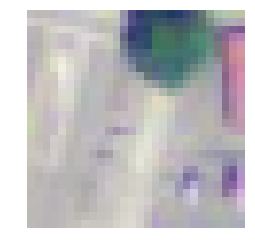

In [8]:
# Generate random index from test_images corpus and display the image
idx = np.random.randint(0, len(test_images))
im = test_images[idx]

#show the test image
print("********** QUERY IMAGE **********")
show_image(idx, test_images)

## Find k nearest neighbour using cosine similarity [slower]

In [9]:
# Compute Vector representation for each training images and normalize those
def generate_db_normed_vectors():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, model_path+"model.ckpt")
        train_vectors = sess.run(net, feed_dict={img_placeholder:train_images})      
    normalized_train_vectors = train_vectors/np.linalg.norm(train_vectors,axis=1).reshape(-1,1)
    return normalized_train_vectors

In [10]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(normalized_train_vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

In [11]:
normalized_training_vectors = generate_db_normed_vectors()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./trained_model/model_triplet/model.ckpt


In [12]:
# Compute vector representation of test image 
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vector = sess.run(net, feed_dict={img_placeholder:[im]}) 
normalized_search_vec = search_vector/np.linalg.norm(search_vector)

INFO:tensorflow:Restoring parameters from ./trained_model/model_triplet/model.ckpt


Total time to find nn: 2.15 ms


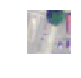

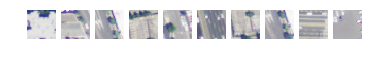

Index of Similar images: [ 9064  9304  4146 19979  2854 15740  3809  8522  8928  5135]


In [13]:
s_time = time.time()
k = 10
candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vec, k)
print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))
fig = plt.figure(figsize=(10, 0.8))
idxs = [idx]
gs = gridspec.GridSpec(1, len(idxs))
# plot test image
for i in range(len(idxs)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
# plot similar images
show_image(candidate_index, train_images)
print("Index of Similar images:", candidate_index)

## VISUALIZATION 

In [14]:
#helper function to plot imageS
def show_top_k_images(indx_list,test_image_indexes, train_data, test_data):
    fig = plt.figure(figsize=(20, 40))
    gs = gridspec.GridSpec(len(indx_list),len(indx_list[0])+2)
    for i in range(len(indx_list)):
        ax = fig.add_subplot(gs[i,0])
        ax.imshow(test_data[test_image_indexes[i],:,:,:])
        ax.axis('off')
        for j in range(len(indx_list[0])):
            ax = fig.add_subplot(gs[i,j+2])
            ax.imshow(train_data[indx_list[i][j],:,:,:])
            ax.axis('off')
    plt.savefig('./figures/similar_images.jpg')
    plt.show()

In [15]:
K = 10
N = 20
indx_list = []
test_image_indexes = []
_test_images = []
for i in range(N):
    idx = i
    test_image_indexes.append(idx)
    _test_images.append(test_images[idx])
    #run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vectors = sess.run(net, feed_dict={img_placeholder:_test_images})
    
normalized_search_vecs = search_vectors/np.linalg.norm(search_vectors,axis=1).reshape(-1,1)
for i in range(len(normalized_search_vecs)):
    candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vecs[i], K)
    indx_list.append(candidate_index)

INFO:tensorflow:Restoring parameters from ./trained_model/model_triplet/model.ckpt


**Query Image**       *************************** Top 10 Similar Images  ***************************


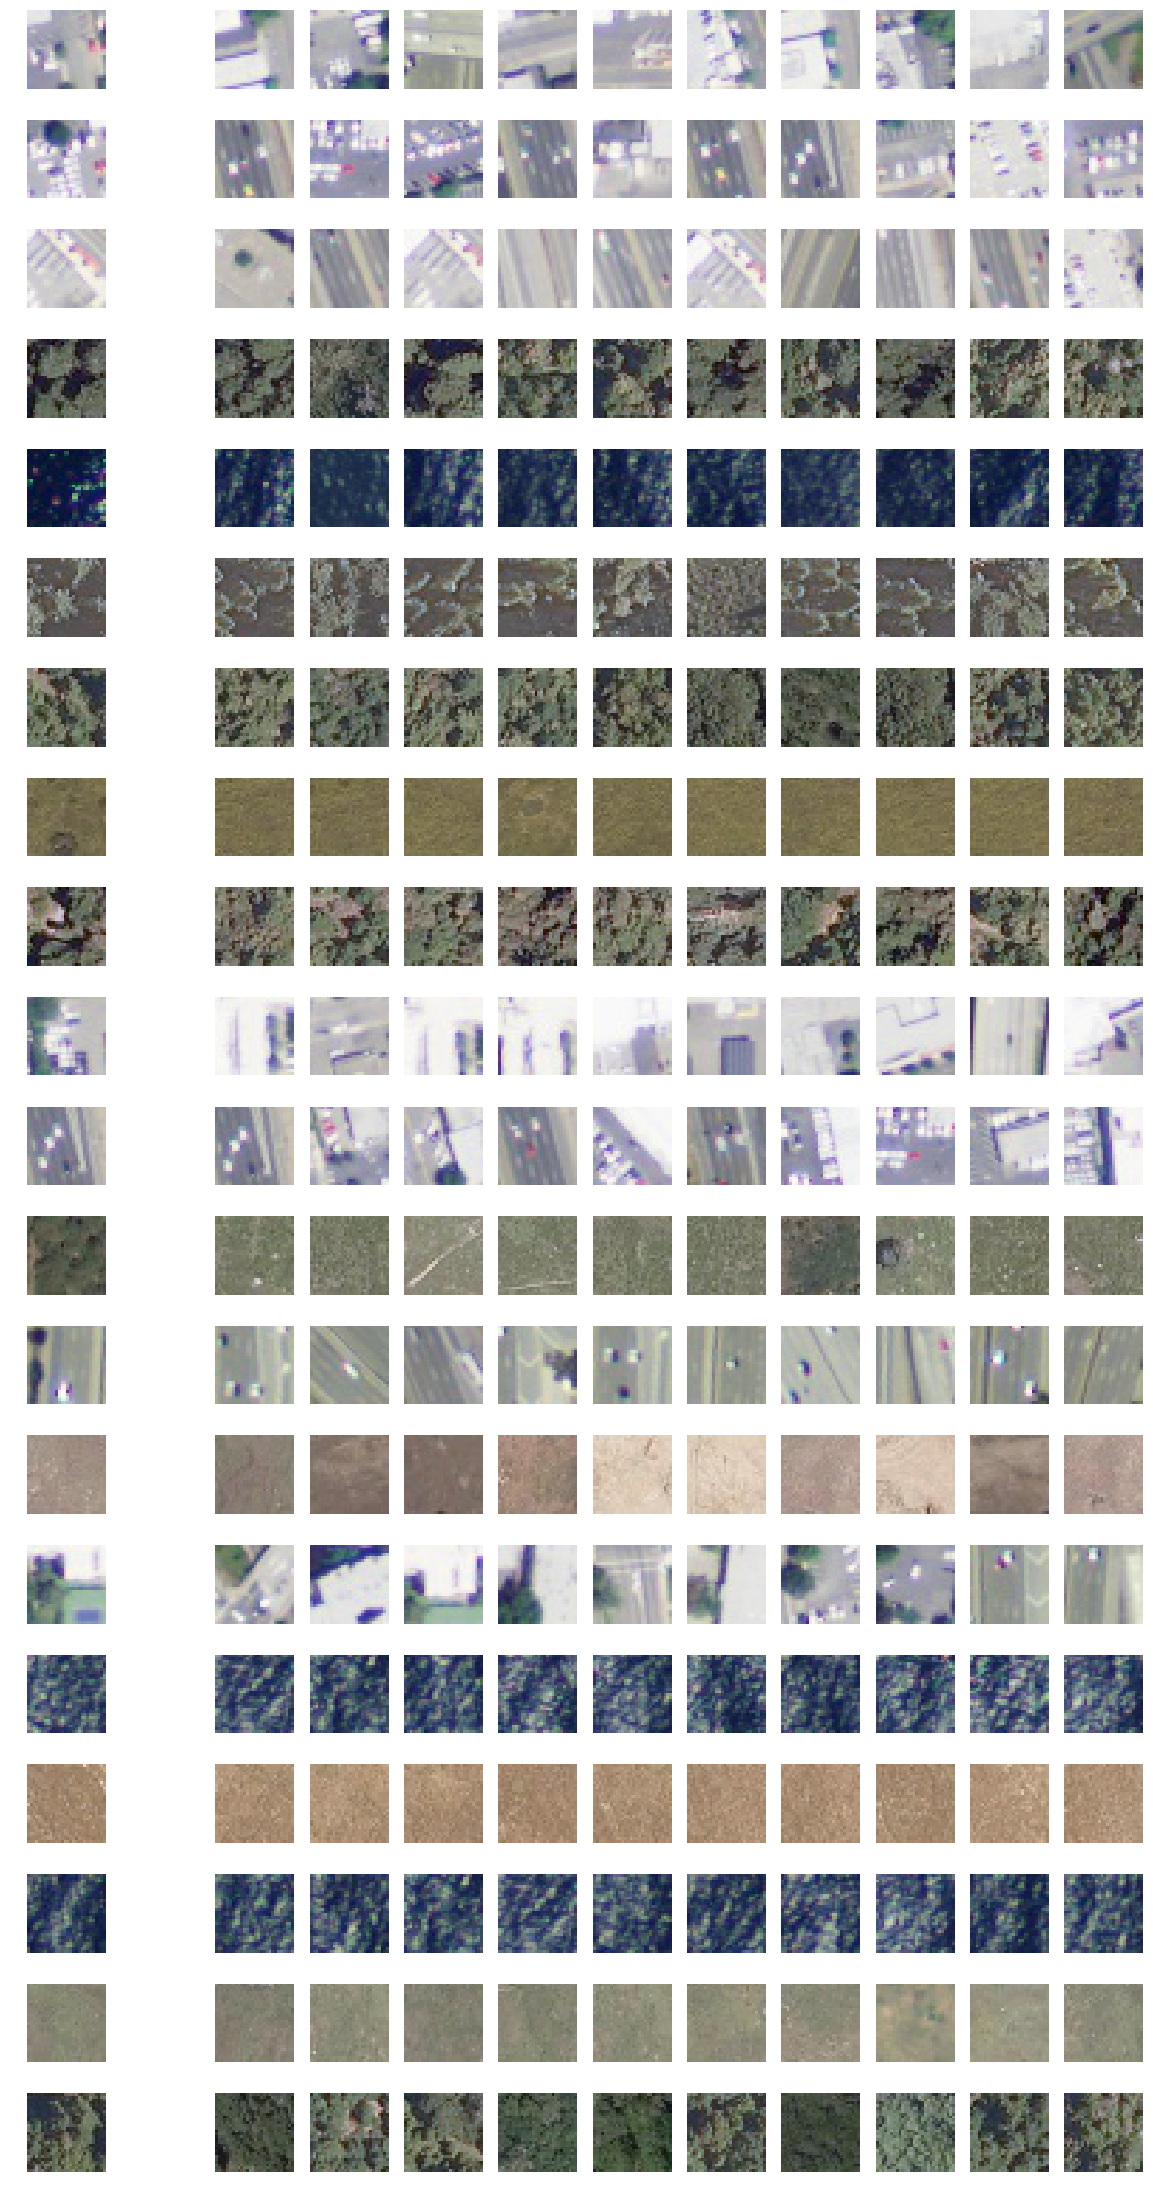

In [16]:
print('**Query Image**       *************************** Top %d Similar Images  ***************************' % K)
show_top_k_images(indx_list,test_image_indexes, train_images, test_images)

## Find k nearest neighbour using faiss [faster]

### prerequisite: faiss [install conda distribution: {conda install -c pytorch faiss-cpu}]

In [17]:
import faiss

In [18]:
def generate_db_index():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, model_path+"model.ckpt")
        train_vectors = sess.run(net, feed_dict={img_placeholder:train_images})   

    d = train_vectors.shape[1]    # Dimension of vector
    index = faiss.IndexFlatIP(d)  # Build the index
    normalized_train_vectors = train_vectors/np.linalg.norm(train_vectors,axis=1).reshape(-1,1)
    index.add(normalized_train_vectors)  # add vectors to the index
    print('faiss indexing done...')
    return index

In [19]:
indexed_db = generate_db_index()

INFO:tensorflow:Restoring parameters from ./trained_model/model_triplet/model.ckpt
faiss indexing done...


INFO:tensorflow:Restoring parameters from ./trained_model/model_triplet/model.ckpt
Total time to find nn: 13.52 ms


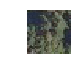

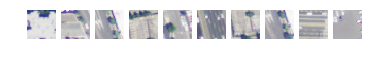

Index of Similar images: [ 9064  9304  4146 19979  2854 15740  3809  8522  8928  5135]


In [20]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vector = sess.run(net, feed_dict={img_placeholder:[im]})
    
s_time = time.time()
normalized_search_vec = search_vector/np.linalg.norm(search_vector)
k = 10

_, candidate_index = indexed_db.search(normalized_search_vec,k)
print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))

fig = plt.figure(figsize=(0.8, 0.8))
idxs = [idx]
gs = gridspec.GridSpec(1, len(idxs))
# Display test image
for i in range(len(idxs)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
# Display similar images
show_image(candidate_index[0], train_images)
print("Index of Similar images:", candidate_index[0])

                           ---------------------- *** --------------------